## Are a single reviewer's scores autocorrelated?  
  
Procedure:
* Plot, for randomly selected reviewers with over 20 reviews, their consecutive scores against review #.
    * Do the same for another subset's BNM awarding behavior
* Look at average time lag between reviews (i.e. if most reviewers review an album on avg every week, we'd let time lag 1 be equivalent to 7 days)
* Compute autocorrelations:
    * For each author, compute autocorrelation using determined time lag
    * Use 1-sample t to see if on avg the autocorrs are significantly diff from 0

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import os
from scipy.signal import savgol_filter
from scipy import stats

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

plt.rcParams['axes.facecolor'] = '0.95'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        db_path = os.path.join(dirname, filename)

# connect to SQL database, create connection object to database
connection = sql.connect(db_path)
print("SQL database connected")

table = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", connection)

reviews = pd.read_sql('SELECT * FROM reviews', connection)
genres = pd.read_sql('SELECT * FROM genres', connection)
connection.close()
print('SQL database connection closed')

SQL database connected
SQL database connection closed


## Cleaning and augmenting data  
We're going to be sorting by review publication date, so as in the EDA let's convert it from str format to unix datetime for ease of use.  
We'll also augment the reviews data with each review's number according to the author's history.

In [2]:
reviews['pub_date'] = pd.to_datetime(reviews.pub_date, format = '%Y-%m-%d')
reviews['unix_time'] = reviews.pub_date.view(np.int64) // 10**9  
"""
 Division by 10^9: 
 We truncate trailing zeros since the int represents seconds elapsed since new year's 1970! 
 However, we leave two trailing zeros (as opposed to dividing by 10^11) since conversion to days later on requires another division by 60*60(*24).

"""

reviews_authns = reviews.copy() # review dataframe, augmented with each review's 'number' i.e. its chronology in author's review history
reviews_authns['review_num'] = pd.Series(index=reviews_authns.index, dtype='int64')
reviews_authns['days_since_prev'] = pd.Series(index=reviews_authns.index, dtype='int64')

for a, rows in reviews_authns.groupby('author'):
    ordered = rows.sort_values(by='unix_time')
    n = ordered.shape[0]
    
    # add review number per author
    nums = list(range(1, n+1))
    reviews_authns.at[rows.index, 'review_num'] = nums
    
    # add days since author's last review
    days = np.zeros(n)
    for i in nums[1:]:
        t_curr = ordered.iloc[i-1].unix_time
        t_prev = ordered.iloc[i-2].unix_time
        days[i-1] = (t_curr - t_prev) / (60*60*24) # convert difference from seconds to days
        
    days[0] = np.nan  # first reviews will not have a 'days since' value
    reviews_authns.loc[ordered.index, 'days_since_prev'] = days

Let's take a coarse look at the average reviewers' scoring behavior over the course of 20 reviews. From the EDA we can see that the median number of reviews that authors write is 10, and the upper quartile starts at 34 reviews. For our purposes, 20 or so reviews will do - we'll randomly choose 5 reviewers with 20 or more reviews from the dataset, then plot against the review number up to 20 their a) scores and b) best new music awards.

In [3]:
over20 = reviews_authns.loc[reviews_authns['review_num'] >= 20]['author']
a_over20 = over20.value_counts().index

revnum = [int(i) for i in range(1, 21)]

random.seed(a=28)
a_rand = random.choices(a_over20, k=5)
a_rand

['rob mitchum',
 'paul thompson',
 'alison fields',
 'tom breihan',
 'larry fitzmaurice']

Text(0.5, 1.0, 'Author BNM awarding behavior over first 20 reviews')

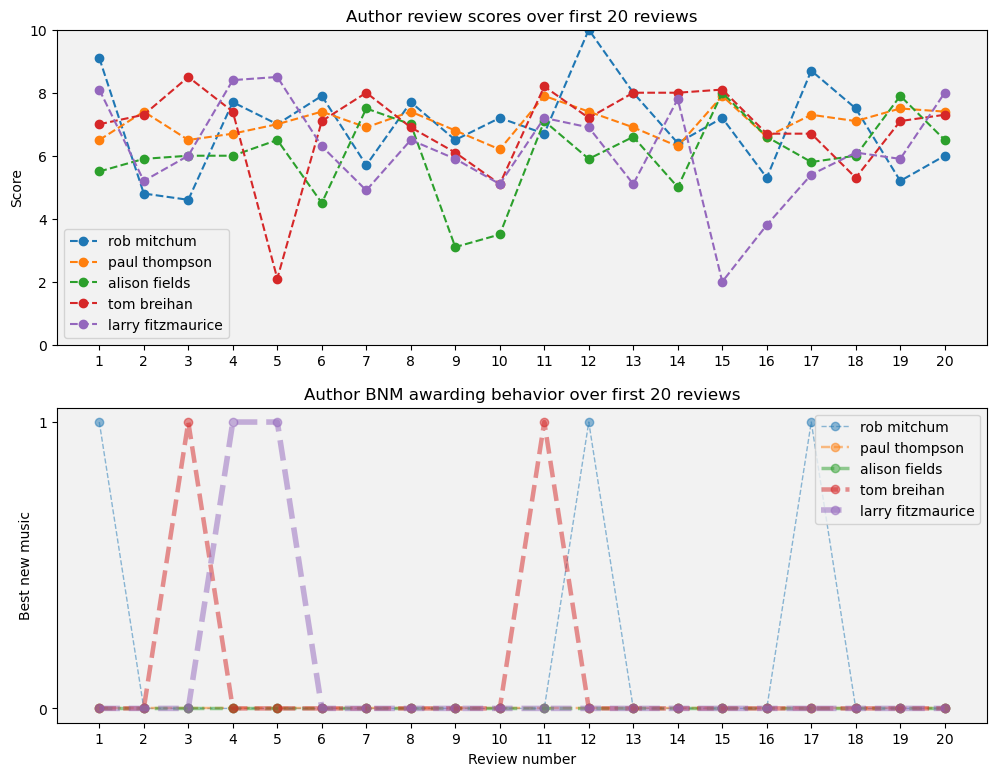

In [4]:
fig, ax = plt.subplots(2, figsize=(12,9))

# plot the authors' scores over 20 reviews on first plot
# plot bnm awarding behavior over same on second plot
width = 1
for author in a_rand:
    temp_auths = reviews_authns.loc[(reviews_authns['author']==author) & (reviews_authns['review_num']<= 20)]
    temp_scores = temp_auths['score']
    temp_bnm = temp_auths['best_new_music']
    
    ax[0].plot(revnum, temp_scores, '--o', label=author)
    ax[1].plot(revnum, temp_bnm, '--o', linewidth=width, alpha=0.5, label=author)
    
    width += 0.75
    
ax[0].set_xticks(revnum)
ax[0].set_ylim([0,10])
ax[0].legend(loc='best')
ax[0].set(ylabel='Score')
ax[0].set_title('Author review scores over first 20 reviews')

ax[1].set_xticks(revnum)
ax[1].set_yticks([0,1])
ax[1].legend(loc='best')
ax[1].set(xlabel='Review number', ylabel='Best new music')
ax[1].set_title('Author BNM awarding behavior over first 20 reviews')

For a quick sanity check, let's see how the BNM awards line up against the score that the author gives: it looks like BNM albums do correspond with high scores (we were even lucky enough to have randomly selected an author who gave a perfect 10!). It's also immediately obvious that BNM awards are most often not followed with another BNM award. It's a little hard to glean insight just from the plots about score autocorrelation, but there also is no obvious pattern of high scores being followed by high scores - if anything, it looks as if most high scores are followed by relative troughs.  
  
Let's follow this visualization with more rigorous autocorrelation analyses. We'll first take a look at the average time between an authors' reviews, to determine how many days will make up one unit of our time lag.

[Text(0.5, 0, 'Days elapsed since previous review'), Text(0, 0.5, 'Frequency')]

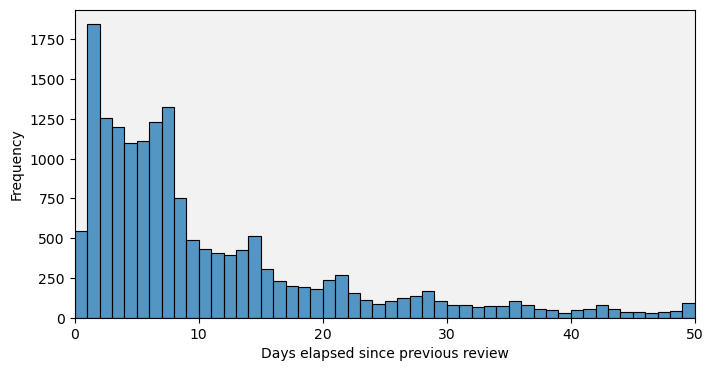

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(reviews_authns['days_since_prev'], binrange=[0,50], bins=50, ax=ax)
ax.set_xlim([0,50])
ax.set(xlabel='Days elapsed since previous review', ylabel='Frequency')

In [6]:
reviews_authns['days_since_prev'].describe()

count    17961.00
mean        19.47
std         80.86
min          0.00
25%          3.00
50%          7.00
75%         16.00
max       3550.00
Name: days_since_prev, dtype: float64

It looks like the median amount of time between an author's consecutive reviews is one week, and the mode is 2 days.  
Since, for the data at hand, it makes the most sense to look at the correlation between an author's review and the one that immediately follows it, we'll be using a lag of 1 - but now we know that sug a lag is on average 7 days, and will take on a value of 2 days more than any other value.

### Computing autocorrelation distributions
For each author, we'll compute an autocorrelation value using a time lag of 1. We'll then use a 1-sample t-test to see if the autocorrelations we've computed, on average, differ from 0. 

In [7]:
def get_reviews(data, col):
    data_sorted = data.sort_values(by='review_num')    
    return data_sorted[col]

Let's also drop authors who have fewer than 5 reviews for the computation of autocorrelations. We choose 5 as the cutoff since we want to retain as much of our data as possible, but too few reviews will compromise the quality of the autocorrelation analysis since, for example, just 2 data points hardly comprises a useful time series. 5 reviews is in the middle of our 2nd quartile, so we will retain roughly 75% of our data.

In [8]:
ac_df = pd.DataFrame(
    index = pd.unique(reviews_authns['author']),
    columns = ['score', 'best_new_music']
)

for author, rows in reviews_authns.groupby('author'): 
    if rows.shape[0] < 5:
        ac_df = ac_df.drop(author)
        continue
        
    for metric in ac_df.columns: 
        rm_sorted = get_reviews(rows, metric)
        ac_df.loc[author, metric] = rm_sorted.autocorr(lag=1)

ac_df = ac_df.astype(float)

score: p = 8.001074809769961e-06
best_new_music: p = 0.42468018303024446


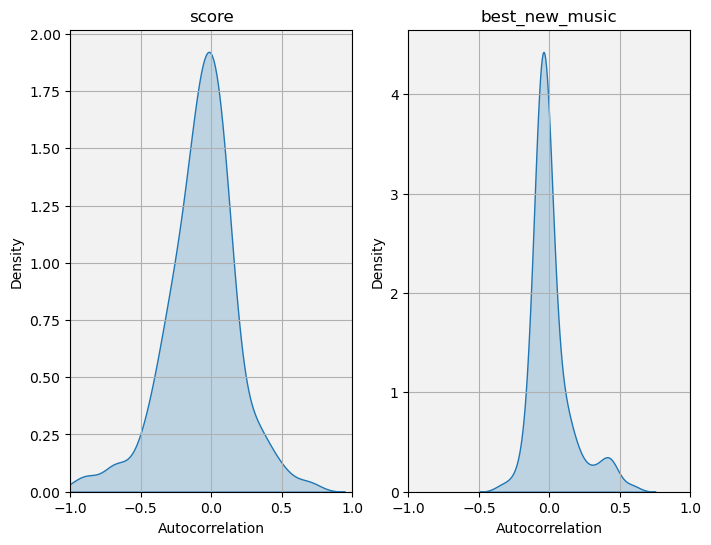

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8,6))
for i, col in enumerate(ac_df.columns.values):
    data = ac_df[col].dropna()
    
    sns.kdeplot(data, ax = axs[i], fill=True)
    p = stats.ttest_1samp(data, 0).pvalue
    print(col + ': p = ' + str(p))
    
    axs[i].set_xlim([-1, 1])
    axs[i].set_title(col)
    axs[i].set_xlabel('Autocorrelation')
    axs[i].set_ylabel('Density')
    axs[i].grid()
    
plt.show()

From the calculated p-values obtained via the 1-sample t-test with the null hyp that the expected value of the autocorrelations of the two metrics is equal to 0, we see that only for the review scores can we reject the null hypothesis. That is, there is some nonzero autocorrelation of review scores with a time lag of 1. From the corresponding density plot, this autocorrelation appears to be slightly negative. We interpret this to mean that high scores are likely to be directly followed by lower scores.

### Examining scoring distributions immediately following unusual scores  

In [10]:
next_revs = pd.DataFrame(index = None, columns = reviews_authns.columns)

for a, rows in reviews_authns.groupby('author'):
    nums = rows['review_num'] + 1
    idxs = (reviews_authns['author'] == a) & (reviews_authns['review_num'].isin(nums))
    next_revs = next_revs.append(reviews_authns.loc[idxs])